# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [14]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend, plot_edges_and_points
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os



## Generating the data

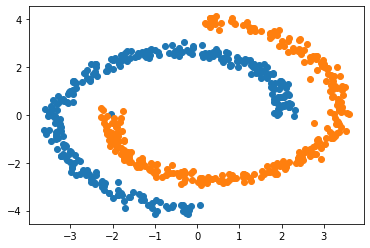

Signature: worst_case_blob(num_samples, delta=5)
Docstring:
Generates a single blob.

:param num_samples: number of samples to create in the blob
:param delta:
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      /media/pezafar/000C612F0C6120C0/Users/Choeb/Desktop/travail/MVA/content/graphs/spectral_clustering/generate_data.py
Type:      function


In [15]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [16]:
%load_ext autoreload
%autoreload 2

def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """

    distances = np.array([np.sum((x - X)**2, axis = 1) for x in X])
    similarities = np.exp(-distances/(2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities * (similarities >= eps)
        np.fill_diagonal(W, 0)

        
    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        new_similarity = similarities.copy()
        np.fill_diagonal(new_similarity, 0.)

        for i in range(n):
            neighbours = np.argsort(- new_similarity[i])[:k]
            W[i,neighbours] = 1
        W = new_similarity * np.maximum(W, W.T)
        


    return W




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


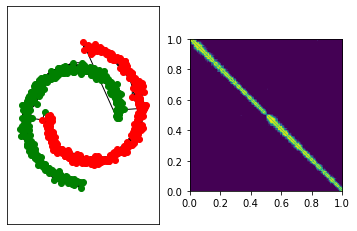

In [221]:
# Example

W = build_similarity_graph(X, eps = 0.82, var = 1)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   

plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W


## Computing the Laplacian

In [52]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    
    # for example (unnormalized): L = D - W
    
    D = np.sum((W > 0), axis = 0)
    if laplacian_normalization == 'unn':
        L = np.diag(D) - W
    
    # Cases where D is not invertible are not taken in account: we suppose each node has at least one edge
    # Otherwise we could take pseudo-inverse or add small float value to D
    elif laplacian_normalization == 'sym':
        D_inv_sq = np.diag(np.sqrt(1/D))
        L = np.eye(W.shape[0]) - D_inv_sq @ W @ D_inv_sq
    elif laplacian_normalization == 'rw':
        L = np.eye(W.shape[0]) - np.diag((1/D))@W
    return L



## Clustering

In [19]:
import scipy

def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, plot_eigval = 0, plot_eigvec = 0):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eig_values, eig_vectors = scipy.linalg.eig(L)
    
    argsort = np.argsort(eig_values)
    
    U = eig_vectors.real[:, argsort]
    E = eig_values.real[argsort]


    # print(E)
    # print(U, E)

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    Y = np.zeros(L.shape[0])
    

    # Select the required eigen values and plot them
    if plot_eigval:
        plt.scatter(range(plot_eigval), E[:plot_eigval])
        plt.title( str(plot_eigval) + " first eigenvalues")
        plt.show()
    
    # Select the required eigen vectors and plot them
    if plot_eigvec:
        fig, axes = plt.subplots(plot_eigvec)
        fig.suptitle(str(plot_eigvec) + " first eigenvectors")
        for i,ax in enumerate(axes):
            ax.scatter(range(U.shape[0]), U[:, i], s = 4)
        plt.show()



    if chosen_eig_indices != None:
        U = U[:, chosen_eig_indices]    
    else:
        U = U[:, 1:num_classes]    

    
    Y = KMeans(n_clusters=num_classes).fit_predict(U)
    return Y    





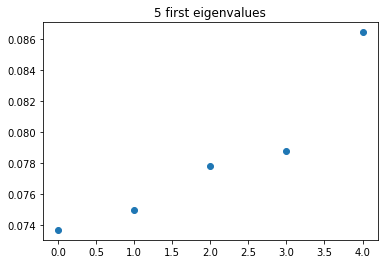

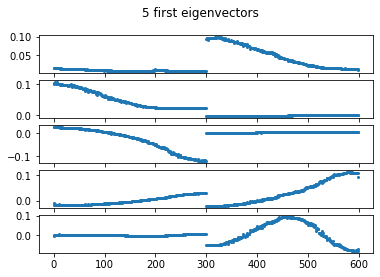

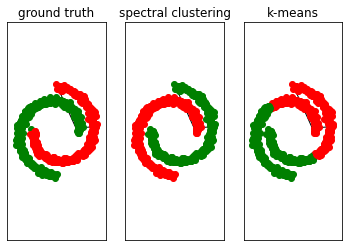

In [222]:
# Example

num_classes = 2
L = build_laplacian(W, laplacian_normalization= 'rw')
# print(L)
# Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0, 1], num_classes=num_classes, plot_eigval = 5, plot_eigvec= 5)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, W, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

## Parameter sensitivity 

In [21]:
def parameter_sensitivity(parameter_type, parameter_candidate, laplacian_normalization, fn_sample):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    # laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    # parameter_type = 'eps' # choose between 'k' or 'eps'
    # parameter_candidate = [1, 2]  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data

        if fn_sample == 'two_moons':
            X, Y = two_moons(num_samples, 1, 0.02)
        elif fn_sample == 'point_and_circle':
            X, Y = point_and_circle(num_samples, 1, 0.02)

        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [212]:
from scipy.ndimage.filters import gaussian_filter



def image_segmentation(input_img='four_elements.bmp', k = 10, var = .5, laplacian_normalization = "unn", num_classes = 5, chosen_eig_indices = None):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    
    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
   
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

See the end of the notebook for the real image clustering

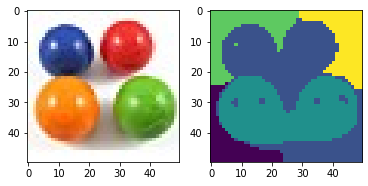

In [97]:
image_segmentation()

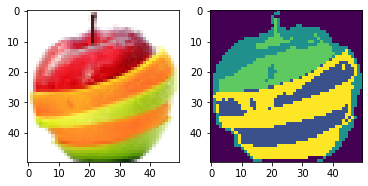

In [24]:
image_segmentation(input_img='fruit_salad.bmp')

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

Let's plot some generated blob with different values of the `delta` parameter

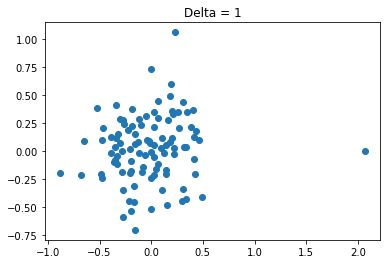

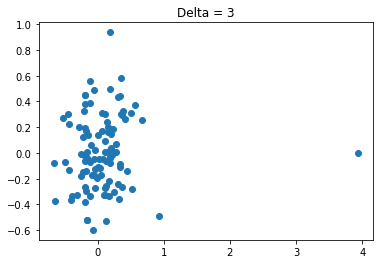

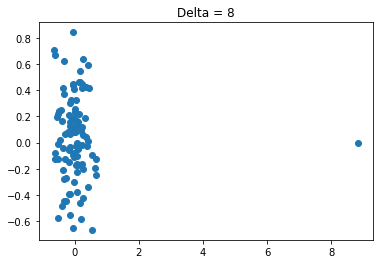

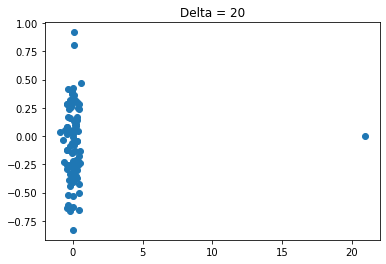

In [25]:
for delta in [1,3,8, 20]:
    X, Y = worst_case_blob(100, delta)
    plot_clusters(X, Y, fignum=str(fn))
    plt.title("Delta = " +  str(delta))
    plt.show()

As we can see and the code of the functions confirms this, the optional parameter `delta` controls how far the outliying point is from the blob.


### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

In [26]:
min_span_tree?

Signature: min_span_tree(W)
Docstring:
:param W: (n x n) adjacency matrix representing the graph
:return: T: (n x n) matrix such that T[i,j] = True if the edge (i, j) is in the min spanning tree, and
            T[i, j] = False otherwise
File:      /media/pezafar/000C612F0C6120C0/Users/Choeb/Desktop/travail/MVA/content/graphs/spectral_clustering/utils.py
Type:      function


In order to keep the graph connected, every point must have his similarity to at least another point above epsilon.


One could consider the two most distant points, and calibrate the epsilon so that the associated similarity is above it, and thus all similarities would be also above. However, the obtained epsilon would be way too large and result in a fully connected graph.

Instead, we can consider the minimum spanning tree built upon the distances, and take the maximum distance between two points in this spanning tree. We can compute the similarity associated, and calibrate epsilon. As a consequence, the similarity of all pairs of nodes in the MST will have a similarity above one computed, and we will get a connected graph in the end with the chosen epsilon.


In [27]:
def compute_cg_eps(X, var = 1):
    """ Compute adapted epsilon to make a connected similarity graph

    Parameters
    ----------
    X : numpy array
    (n x m) matrix of m-dimensional samples
    """
    n = X.shape[0]
    
    distances = np.array([np.sum((x - X)**2, axis = 1) for x in X])

    # Build spanning tree and take distances of the mst edges
    mst = min_span_tree(distances)
    distances = mst * distances
    
    # Compute epsilon with the maximum distnce in the mst        
    epsilon =  np.exp(-np.max(distances)/(2*var))

    return epsilon

Now let's use this specific epsilon with different values of the `delta` parameter:

Delta =  1 esp =  0.530808646187565


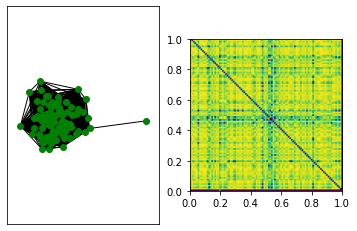

Delta =  3 esp =  0.007960947687527024


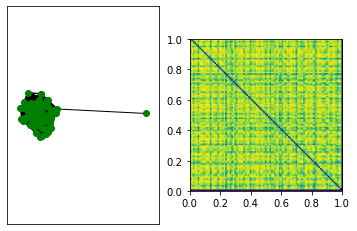

Delta =  8 esp =  9.468983377186145e-15


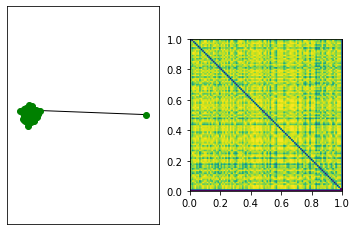

Delta =  20 esp =  1.2960292497786188e-87


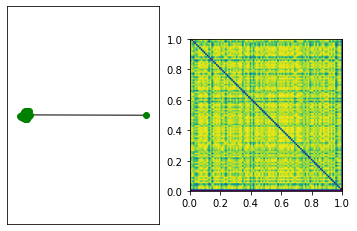

In [28]:
for delta in [1,3,8, 20]:
    n= 100
    X, Y = worst_case_blob(n, delta)
    var = 1
    
    epsilon = compute_cg_eps(X)

    # Plot
    print("Delta = ",  delta, "esp = ", epsilon)
    W = build_similarity_graph(X, eps = epsilon, var = 1)

    plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

    # plt.show()


As expected the selected value of $\epsilon$ decreases when the outlier is at a bigger distance (because we made sure it would be included in the graph). Thus when the outlier is too far, this will force all edges thus resulting in a fully connected graph, not sparse. Moreover, with mutiple blobs and a far outlier, all blobs will be connected.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

By using k-NN, we can easily connect one outlier to a distant blob for instance as the outlier will reach its closest neighbour within the blob. However when increasing the number of outliers, it requires to take an increasing number of neighbours to reach a distant blob. 

Using an $\epsilon$-graph allows to make edges inependantly of the number of points but requires to have an information on the geometry of the points. When $\epsilon$ is getting bigger, we risk getting a fully connected graph.


### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

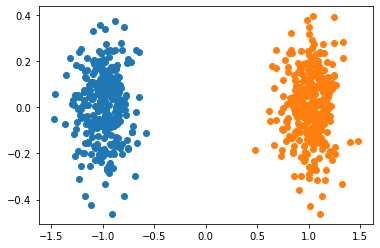

Signature: blobs(num_samples, n_blobs=2, blob_var=0.15, surplus=0)
Docstring:
Creates N gaussian blobs evenly spaced across a circle.

:param num_samples: number of samples to create in the dataset
:param n_blobs:      how many separate blobs to create
:param blob_var:    gaussian variance of each blob
:param surplus:     number of extra samples added to first blob to create unbalanced classes
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      /media/pezafar/000C612F0C6120C0/Users/Choeb/Desktop/travail/MVA/content/graphs/spectral_clustering/generate_data.py
Type:      function


In [29]:
blobs?
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

Let's build a similarity graph, and use a smaller $\epsilon$ (5 times smaller, experimentally) than the one computed with the MST in order to make the graph more connected to better illustrate how a connected graph behaves with spectral clustering.

We also plot the first eigenvalues and eigenvectors to see what is happening.

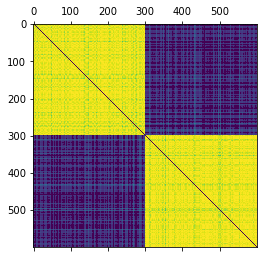

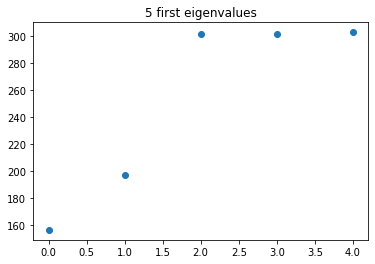

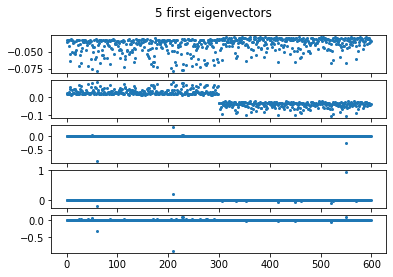

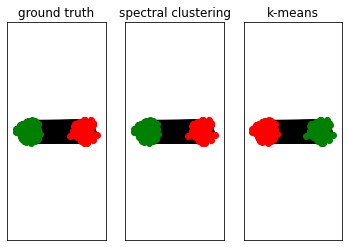

In [30]:
var = 1
epsilon = compute_cg_eps(X, var)
# W = build_similarity_graph(X, eps = epsilon*0.9, var=var)
W = build_similarity_graph(X, eps = epsilon*0.2, var=var)

plt.matshow(W)
plt.show()



num_classes = 2
L = build_laplacian(W, laplacian_normalization= 'unn')
# Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes, plot_eigval= 5, plot_eigvec= 5)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

The first eigenvalue is equal to 0 and corresponds to the connected component (the whole graph) and thus is not useful to get culstering information. We thus use the second eigenvalue, whose eigenvector components change signs as we can see on the eigenvectors plots. We can see here we could apply the heuristic seen in course of assigning to the cluster depending on the sign of the eigenvector component.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

This time, we can use a slightly bigger $\epsilon$ than the one computed with the MST, in order to have 2 connected components.

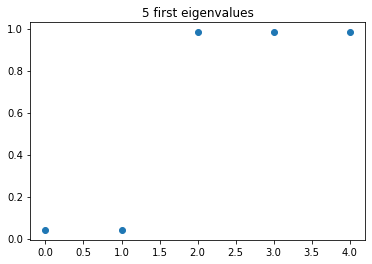

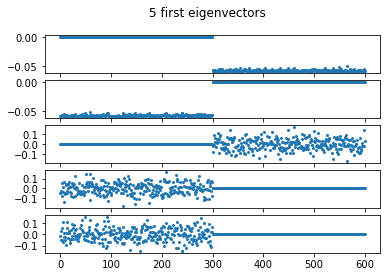

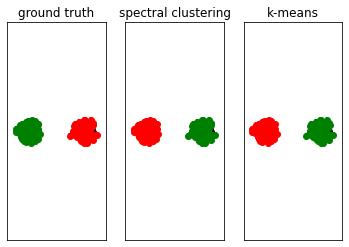

In [31]:
# Take the double of the previous epsilon to delete the edge between the two blobs
epsilon = compute_cg_eps(X)*1.2

W = build_similarity_graph(X, eps = epsilon)

num_classes = 2
L = build_laplacian(W, laplacian_normalization= 'rw')
# print(L)
# Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)
Y_rec = spectral_clustering(L, chosen_eig_indices=[0, 1], num_classes=num_classes, plot_eigval= 5, plot_eigvec= 5)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

Here, we can see that the first eigenvector would allow us to differentiate the two clusters. HEre we can see that the two first eigenvalues (0) orrespond to each of the connected components in the graph.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

As per the previous observations, if the graph is connected, the first null eigen value is useless and corresponds to the whole conected component. Thus we can use the next eigenvalues, and more precisely, when clustering into $k$ classes, we only need $k-1$ vectors to split the points into $k$ classes.

Thus the method we can apply is, having $(e_1, ..., e_n)$ the sorted eigenvalues, to seleect the eigenvectors corresponding to $(e_2, ..., e_k)$.

Additionally, we could try to check if the graph is connected to take the first eigenvector if not, but it doesn't appear to be necessary when having the $k-1$ next ones.

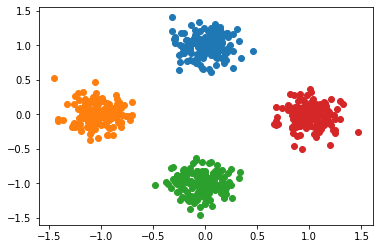

In [32]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)	

Let's build a graph out of those 4 blobs

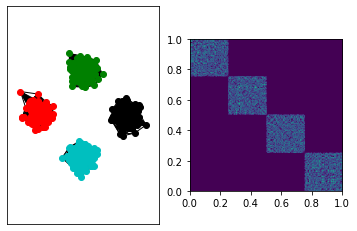

In [33]:
W = build_similarity_graph(X, k = 30)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

num_classes = 4
L = build_laplacian(W, laplacian_normalization= 'rw')
# print(L)
# Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)


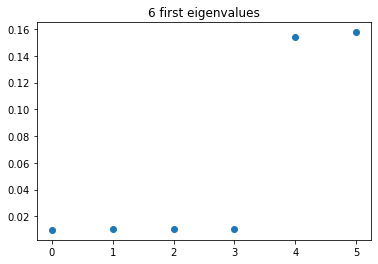

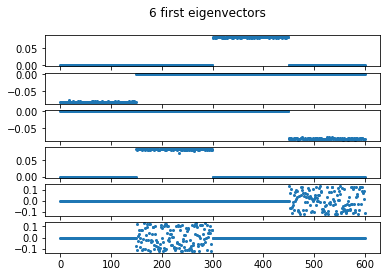

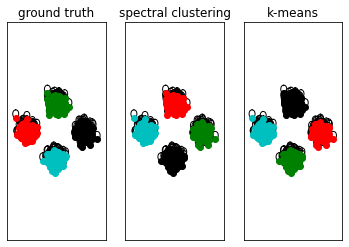

In [34]:
Y_rec = spectral_clustering(L, num_classes=num_classes, plot_eigval=6, plot_eigvec=6)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

The method has chosen the second, third and fourth eigenvectors (4 classes). Once again, on the plot of the eigenvectors, we can see to which cluster each eigenvector corresponds to.

When the variance of the blobs increase, it becomes more and more difficult to create interconnected cluters in the graph, thus to use the selected eigenvalues to apply spectral clustering. below is an eample with an high variance to illustrate this.

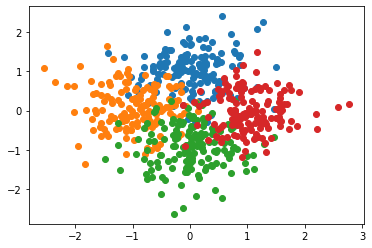

In [35]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var= .5)
plot_clusters(X, Y)

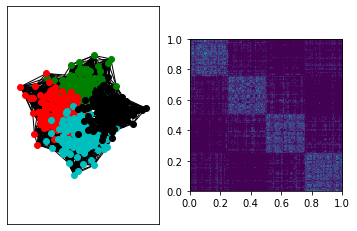

In [36]:
W = build_similarity_graph(X, k = 30)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

num_classes = 4
L = build_laplacian(W, laplacian_normalization= 'rw')
# print(L)
# Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)


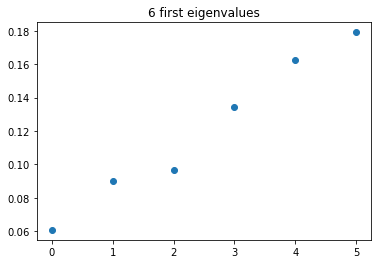

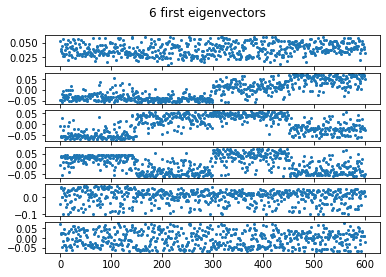

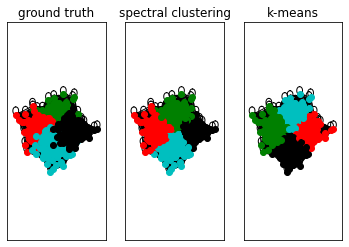

In [37]:
Y_rec = spectral_clustering(L, num_classes=num_classes, plot_eigval = 6, plot_eigvec = 6)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

When increasing the variance of the blobs, the clusters mix, and the resulting graph has a lot more of edges betwee clusters.
As a consequence, the obtained eigenvalues and eigenvectors depict more difficultly the clusers geometry, and the clustering cannot differentiate outliers from other blobs. 

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

in order to get better generalization, I used K-means in the cluster assignments. Thresholding could be used for two classes only, but for 3 and more, K-means seem to be efficient at clustering the resulting points we obtained from the eigenvectors values.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

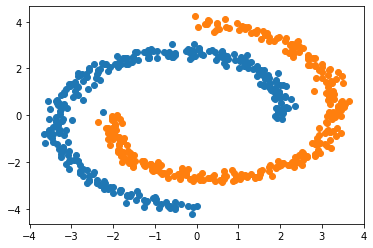

Signature: two_moons(num_samples, moon_radius=2.0, moon_var=0.02)
Docstring:
Creates two intertwined moons

:param num_samples: number of samples to create in the dataset
:param moon_radius: radius of the moons
:param moon_var:    variance of the moons
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment
File:      /media/pezafar/000C612F0C6120C0/Users/Choeb/Desktop/travail/MVA/content/graphs/spectral_clustering/generate_data.py
Type:      function


In [215]:
two_moons?
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

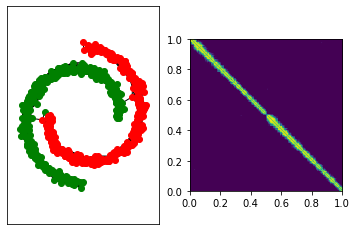

In [216]:
W = build_similarity_graph(X, eps = 0.8, var = 1)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

num_classes = 2
L = build_laplacian(W, laplacian_normalization= 'rw')

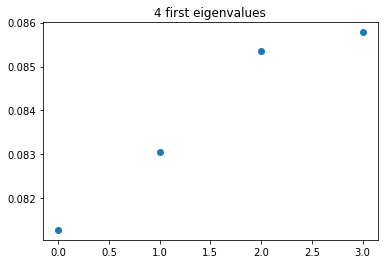

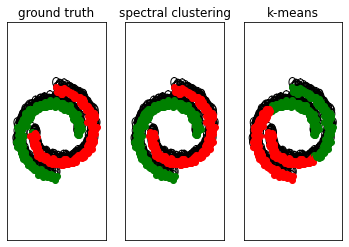

In [217]:
Y_rec = spectral_clustering(L, num_classes=num_classes, plot_eigval=4)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

With can notice that the spectral clustering with well chosen eigen values is much more efficient. Indeed, with Kmeans, given the intricated shapes on the moons, the Kmeans can't extract information only using distance, thus create two opposite clusters that get both moons points.

On the opposite, because within each cluster points are close to each other, the graph edges we built are much more efficient in representing the inner cluster structures, thus spectral clustering  


### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

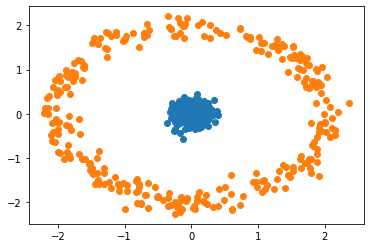

Signature: point_and_circle(num_samples, radius=2.0, sigma=0.15)
Docstring:
Creates point and circle

:param num_samples: number of samples to create in the dataset
:param sigma:       variance
:param radius:      radius of the circle
:return: X,  (num_samples, 2) matrix of 2-dimensional samples
         Y,  (num_samples, ) vector of "true" cluster assignment in {0, ..., c-1}
File:      /media/pezafar/000C612F0C6120C0/Users/Choeb/Desktop/travail/MVA/content/graphs/spectral_clustering/generate_data.py
Type:      function


In [46]:
point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

Let's build the graph

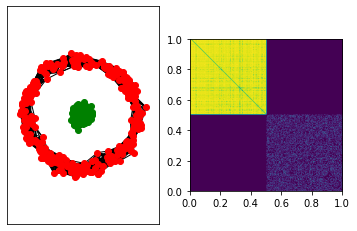

In [49]:
W = build_similarity_graph(X, eps = 0.8, var = 1)
plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W
num_classes = 2

Unnormalized Laplacian

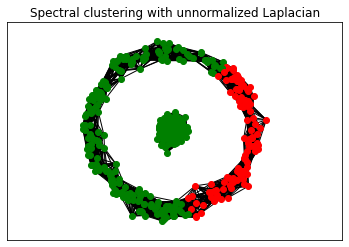

In [50]:
L = build_laplacian(W, laplacian_normalization= 'unn')
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_edges_and_points(X,Y_rec, W)
plt.title("Spectral clustering with unnormalized Laplacian")
# plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
plt.show()

Random-Walk Laplacian

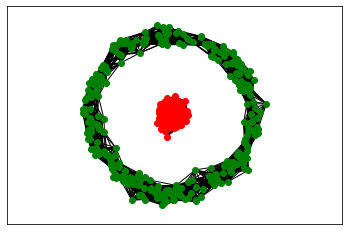

In [51]:
L = build_laplacian(W, laplacian_normalization= 'rw')
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plt.title("Spectral clustering with Random-Walk Laplacian")
plot_edges_and_points(X,Y_rec, W)
plt.show()

We can observe that using the Random Walk Laplacian works way better. The normalized Laplacian and RAndom-Walk Laplacian are respetively used for approximating Ratio Cut and N-Cut. However, N-Cut is based on the volume of the clusters and not only the number of edges. Thus in our situation, the random walk Laplacian works better as the blobs are very localised and have very strong interconnectivity, which leads to better results with a random-walk view of the problem. 

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

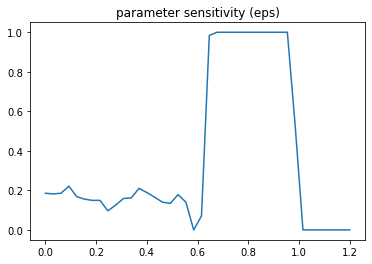

In [55]:
parameter_sensitivity('eps', np.linspace(0, 1.2, 40), laplacian_normalization = 'unn', fn_sample = 'point_and_circle')

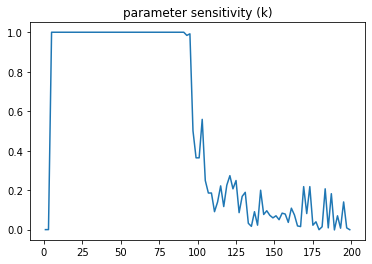

In [53]:
parameter_sensitivity('k', range(1, 200, 2), laplacian_normalization = 'unn', fn_sample=  'point_and_circle')

The way we cluster a graph depends on how the edges are chosen. As we can wee, for low values of $k$(below 5) /$\epsilon$ (below .6 in this example) (meaning that we connect few neighbours resp. we connect only very similar points) the performance is very poor. In fact, almost no edges are made, thus the structure of the data cannot be used efficiently for clustering Then we observe in both case a range of $k$/$\epsilon$ where the score is maximum and constant. However for extreme values, we see the score collapsing, probably because we get a more and more connected graph, and clusters cannot be identified anymore becaue of a too high connectivity. 

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

To evaluate the clustering in this situation, we could use an intrinsic measure as the Silhouette coefficient or Davies-Bouldin score. However, the result would highly depend on the type of data we are facing wrt how the performance measure operates. In any case, as we have seen, K-means can perform very badly and would not be a good performance reference in a lot of cases.

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

I used around 50-60 closest neighbours for the similarity graph building which lead to reasonable results. We can see that it is difficult to include the white reflections in the balls given that only their color is considered overall (no position information was injected in the points we build the graph with).

Using more neighbours lead to better segmentation as we built edges between enough. I showed an extreme case whe, using only 3 neighbours below and the graph built doesn't represent information about what groups of colors are present. 

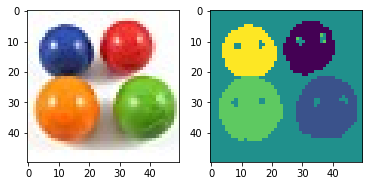

In [125]:
image_segmentation(input_img="four_elements.bmp", k = 60, var = 1, laplacian_normalization= "rw", num_classes=5, chosen_eig_indices=None)

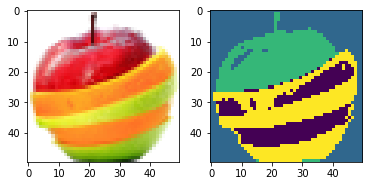

In [129]:
image_segmentation(input_img="fruit_salad.bmp", k = 80, var = 1.0, laplacian_normalization= "rw", num_classes=4)


A bad case :

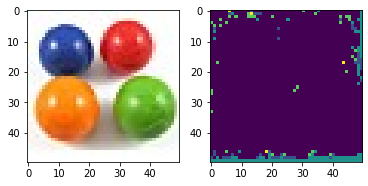

In [213]:
image_segmentation(input_img="four_elements.bmp", k = 3, var = 1, laplacian_normalization= "rw", num_classes=5, chosen_eig_indices=None)


### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

* In order to reduce te occupational cost of such a big graph, we can use a sparse matrix representation (practically using scipysparse for instance) which does not store the zero-values and associated indices (ie. only stores the existing edges for a graph).

* Concerning computational cost, we could down sample the image to operate with less points, this would also save space, bu we might face visual issues in the clustering as we would have to reattribute the clusters when upsampling.
* Finally, as each node is one pixel, we could try to merge some very similar points in term of color. For instance, lower the precision of color quantization, currently 8 bits per channel, to 6 or 4 bits, and map each group of identical pixels (in color) to one point in the color space. 

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

Below I chose to downample the image before clustering in the function `image_segmentation_2`.

I decided to implement scaling own of the image (using sparse matrix might have necessitated rewriting several parts of the spectral clustering so I decided no to for time problems).

I a first step, the image is scaled down by a given factor.
Then spectral clustering is applied as before, the clustering result (an image of cluster assignments) is then upscaled, and rounded to the closest integer (we want integer classes).

To upscale the image of class values is actually a bad idea as an interpolated pixel between class 1 and 3 could end up in class 2 which has nothing to do with the two previous classes.

I could have use a K-NN to attribute the classes of the upscaled-back image.

As expected, we lose some precision in the clustering of border zones notably, but given the gained time, this could be a first pass to be improved.

The clustering results are bad on this image, but I did not have time to tweak the parameters for this one.

In [210]:
# The image I tested the code on
!wget https://tennishead.net/wp-content/uploads/2020/10/Roland-Garros-Ball-2020-1024x512.jpg -O data/tennis.jpg -q

In [198]:
from skimage.transform import resize

In [194]:
def image_segmentation_2(input_img='four_elements.bmp', k = 10, var = .5, laplacian_normalization = "unn", num_classes = 5, blur = False, chosen_eig_indices = None):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    print(X.shape)

    # Scaled down original image
    SCALE_FACTOR = 12
    scaled_X = resize(X,(X.shape[0] // SCALE_FACTOR, X.shape[1] // SCALE_FACTOR, 3))
    print("Scaled")


    # Clustering
    w,h = scaled_X.shape[0], scaled_X.shape[1]
    Xr = scaled_X.reshape(w*h, 3)
    print(scaled_X.shape)

    W = build_similarity_graph(Xr, var=var, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)


    # Scale up and round values
    s = Y_rec.max()
    Y_rec = Y_rec.reshape(w, h)
    Y_rec_scaled = np.rint(resize(Y_rec/s, (X.shape[0], X.shape[1]))*s)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.subplot(1, 2, 2)
    plt.imshow(Y_rec)
    plt.show()

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X)
    plt.subplot(1, 2, 2)
    plt.imshow(Y_rec_scaled)
    plt.show()

    return Y_rec, Y_rec_scaled

(512, 1024, 3)
Scaled
(42, 85, 3)


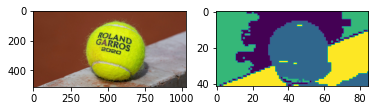

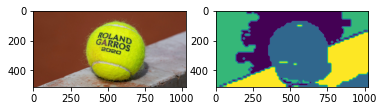

In [195]:
Y_rec, Y_rec_scaled = image_segmentation_2(input_img="tennis.jpg", k = 60, var = 1, laplacian_normalization= "rw", num_classes=4, chosen_eig_indices=None)


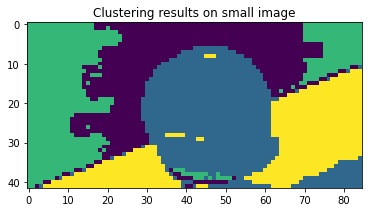

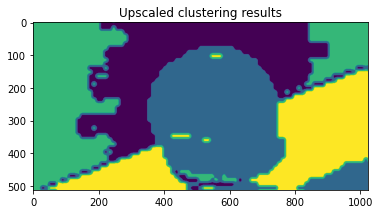

In [200]:
plt.title("Clustering results on small image")
plt.imshow(Y_rec)
plt.show()
plt.title("Upscaled clustering results")
plt.imshow(Y_rec_scaled)